# Testing a Fake Dictionary Against its Training Dictionary
In this chapter, we'll inspect the quality of the generated pseudo-words. One interesting aspect about training the model on a full dictionary is that we get some fairly rare instances, and we can see, when generating an equally large set of words, how well was the training set "digested" by our model. For instance, our set of Breton lemmas only contains 31 items starting with the character "z" on out of a total of 62 172 items. That is 0.05% chances of having a word starting with a "z" or 1 chance for 2005 items. As we don't only want our model to learn the main traits of our lexis, but the entire diversity of what a "plausible" word in the language looks like, we want our model to be able to reproduce such outlier in similar proportions. One can only inspect this, we start by producing an equally large set of pseudo-words as the original set of words (see chapter 2) before analyzing it in here.

## 1. General Characters Distribution
First, let's take a look at the distribution of characters regardless of their position in the words. Even a fairly accurate model, one which was trained with a low cross-entropy (below 1.8 is excellent) can produce words that look all "alike", think of the "most plausible words", if the temperature were too low. Otherwise, if the temperature is too high, the probabilities painfully learnt by the model during training would be offset by a too strong randomization. We start by loading the items.

In [284]:
import json

locale = "br"
lemmas_file_path = f"locales/{locale}/lemmas.json"
pseudo_lemmas_file_path =  f"locales/{locale}/pseudo-lemmas.json"

try:
    with open(lemmas_file_path) as f:
        content = f.read()
        if not content.strip():
            raise ValueError("The JSON file is empty.")
        lemmas = json.loads(content)
except FileNotFoundError:
    print(f"Error: File not found at {lemmas_file_path}")
    lemmas = []
except ValueError as e:
    print(f"Error: {e}")
    lemmas = []
except json.JSONDecodeError:
    print(f"Error: Invalid JSON content in {lemmas_file_path}")

try:
    with open(pseudo_lemmas_file_path) as f2:
        content2 = f2.read()
        if not content2.strip():
            raise ValueError("The JSON file is empty.")
        pseudo_lemmas = json.loads(content2)
except FileNotFoundError:
    print(f"Error: File not found at {pseudo_lemmas_file_path}")
    pseudo_lemmas = []
except ValueError as e:
    print(f"Error: {e}")
    pseudo_lemmas = []
except json.JSONDecodeError:
    print(f"Error: Invalid JSON content in {file_path}")

print(f"{len(lemmas)} items loaded from {lemmas_file_path}:\n" + "\n".join(lemmas[:7]))
print(f"{len(pseudo_lemmas)} items loaded from {pseudo_lemmas_file_path}:\n" + "\n".join(pseudo_lemmas[:7]))


62169 items loaded from locales/br/lemmas.json:
'gozik
'keda
'kre
're
'ta
'tav
'toue
62172 items loaded from locales/br/pseudo-lemmas.json:
''ed
'hudinal
'isonaj
'odadur
a-ahennid
a-amant
a-amantoù


First, let's look at the average length difference between the two. As we can see below, the pseudo-words are in average a little longer than their real counterparts.

In [74]:
lemmas_str = "".join(lemmas)
pseudo_lemmas_str = "".join(pseudo_lemmas)
print(len(lemmas_str)/len(lemmas))
print(len(pseudo_lemmas_str)/len(lemmas))

8.250639386189258
8.759204748347248


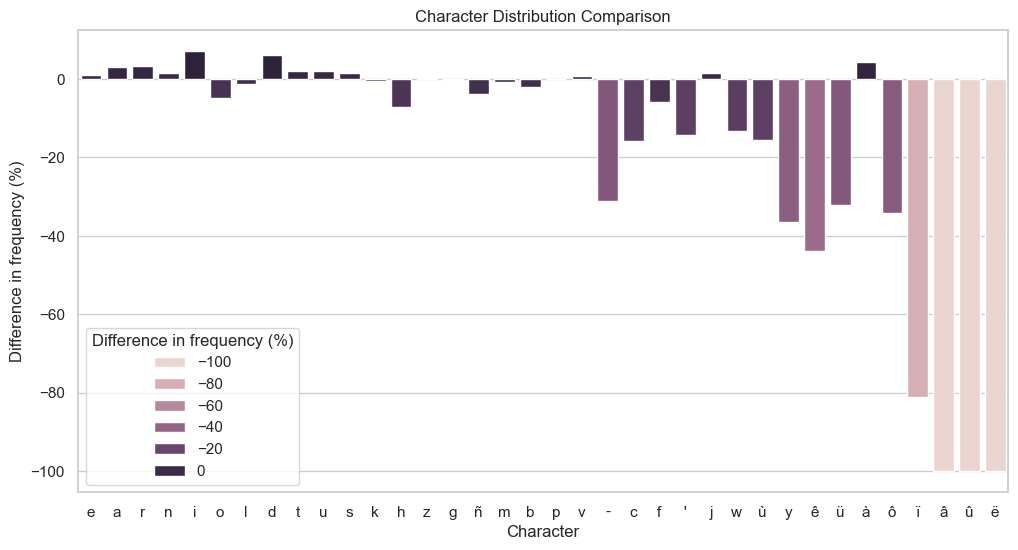

In [230]:
import numpy as np
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt
from collections import Counter

cmap = plt.cm.viridis
sns.set_theme(context='notebook', style="whitegrid", palette="pastel")

chars = set(lemmas_str + pseudo_lemmas_str)
counter_lem = Counter(lemmas_str)
counter_psd = Counter(pseudo_lemmas_str)

data = []
for char in chars:
        freq_lemmas = (counter_lem.get(char, 0) / len(lemmas_str)) * 100 if lemmas_str else 0
        freq_pseudo_lemmas = (counter_psd.get(char, 0) / len(pseudo_lemmas_str)) * 100 if pseudo_lemmas_str else 0
        data.append({'Character': char, "lemmas": freq_lemmas, "pseudo_lemmas": freq_pseudo_lemmas})


df = pd.DataFrame(data)
df['avg'] = (df["lemmas"] + df["pseudo_lemmas"]) / 2
df['Difference in frequency (%)'] = (df["lemmas"] - df["pseudo_lemmas"]) * -100 / df["lemmas"]
df = df.sort_values('avg', ascending=False).drop('avg', axis=1)

# Plot
plt.figure(figsize=(12, 6))
sns.barplot(x='Character', y='Difference in frequency (%)', hue='Difference in frequency (%)', data=df)
plt.title('Character Distribution Comparison')
plt.show()

As expected, there are a few variations, especially as the characters become rarer, the variations become more important. Some low frequency characters however display a higher frequency in the generated set. This may be explained by the fact that the characters in questions mostly appears within regular structures, like "'", which mostly appears between "c" and "h", in the trigram "c'h", a frequent letter in Breton, same thing for "à" which often occurs as a contraction to "war" ("àr" meaning on, upon) in the beginning of a word. Conversely, the location of the hyphens seem to have confused the model to a point that it did not learn properly where to place it. Some characters were not generated at all, but their frequency in the training set is very low, 1 to 5 for the entire set. The higher frequency of some rare characters in the generated set indicates a propensity of the model to learn the structures rather than pure probabilities, which is encouraging.  

Next we'll look at the length distribution of the sets.


    Lemmas Lengths  Pseudo-Lemmas Lengths
0                0                      0
1                0                      0
2              109                      6
3              745                    120
4             2003                    614
5             4365                   2442
6             8089                   6191
7             9843                   9485
8            10369                  11653
9             9340                  11100
10            6839                   8186
11            4634                   5371
12            2750                   3325
13            1411                   1807
14             808                    925
15             378                    408
16             202                    234
17             105                    111
18              69                     75
19              45                     38
20              25                     27
21              15                     20
22               9                

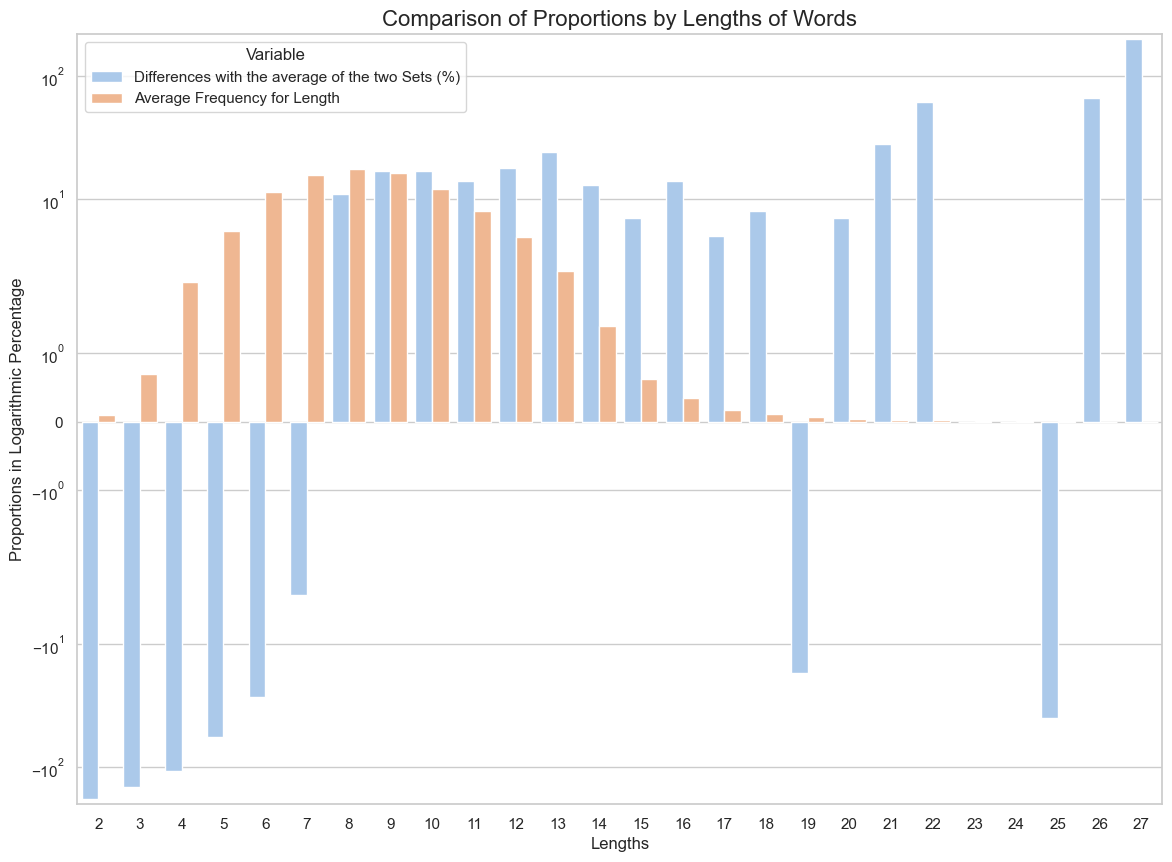

In [279]:
cmap = plt.cm.viridis
sns.set_theme(context='notebook', style="whitegrid", palette="pastel")

lemmas_counter = dict(Counter([len(l) for l in lemmas]))
pseudo_lemmas_counter = dict(Counter([len(l) for l in pseudo_lemmas]))
data = []
for i in range(max([i for i in lemmas_counter.keys()] + [i for i in pseudo_lemmas_counter.keys()]) + 1):
    data.append({
        "Lemmas Lengths": lemmas_counter[i] if i in lemmas_counter else 0,
        "Pseudo-Lemmas Lengths": pseudo_lemmas_counter[i] if i in pseudo_lemmas_counter else 0
    })


lengths_df = pd.DataFrame(data)
print(lengths_df)
lengths_df["avr"] = (lengths_df["Lemmas Lengths"] + lengths_df["Pseudo-Lemmas Lengths"]) / 2
lengths_df["Average Frequency for Length"] = (100 * lengths_df["avr"] / len(lemmas))
lengths_df["Length Difference"] = lengths_df["Pseudo-Lemmas Lengths"] - lengths_df["Lemmas Lengths"]
lengths_df["Differences with the average of the two Sets (%)"] = (100 * lengths_df["Length Difference"] // (lengths_df["avr"]))

lengths_df.index.name = 'Lengths'
lengths_df = lengths_df.drop([0, 1])

df_long = lengths_df.reset_index().melt(id_vars=['Lengths'], value_vars=['Differences with the average of the two Sets (%)', 'Average Frequency for Length'])
plt.figure(figsize=(14, 10))
sns.set_style('whitegrid')


bar_plot = sns.barplot(
    x='Lengths',
    y="value",
    hue="variable",
    data=df_long
)
plt.yscale('symlog')

# Customize the plot
plt.title('Comparison of Proportions by Lengths of Words', fontsize=16)
plt.xlabel('Lengths', fontsize=12)
plt.ylabel('Proportions in Logarithmic Percentage', fontsize=12)
plt.legend(title='Variable')
plt.show()

Here we see that the lengths of the generated words varies greatly from the training set. The explanation is straightforward, the scarcity of items with either few or large numbers of characters forbid the model to learn properly to create long or short words. One of the explication for the lack of short words may be due to the fact that a large part of the plausible short words are "already taken" and that the model initially generated the right amount of short words, but did not retain them in the final list because those words were real. But if the model did not learn well to reproduce the exact probabilities of short or long words, it still did what would be impossible for a gram-based HMCM. It can create two-characters-long words and even words (at least one in this set) longer than anything it has ever seen during training. This underscores once again the successful learning of patterns over pure distributions.

Finally, we'll look at the frequencies for first characters.
